In [1]:
'Random forest emulation for the ∆LWP_conv*A_conv*Incoming_Solar vs ∂LWP/∂WCB colored by ∆CRE'

'Random forest emulation for the ∆LWP_conv*A_conv*Incoming_Solar vs ∂LWP/∂WCB colored by ∆CRE'

In [1]:
'''Started on 05/07/25
last edited on 06/13/25'''

'Started on 05/07/25\nlast edited on 06/13/25'

# imports

In [2]:
import gc
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [3]:
gc.collect()

54

In [4]:
from load_xarray import *


In [5]:
from lat_weight_mean import *


In [6]:
from TOAf import *

# load data

In [7]:
LWP_varn="dLWPmap_gol"; T_varn="dTSmap_gol"; ocean=False
Lv = 2264705.  # J/kg
### Load maps
file_names = {
    "dLWPmap": LWP_varn,
    "dTSmap": T_varn,
    "pe_maps_ol": "pe_maps_ol",
    "pe_maps_o": "pe_maps_o"
}
datasets = {var_name: load_xarray(file_name) for var_name, file_name in file_names.items()}

### ∆LWP map
dLWP_TSmap = datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
dLWP_TSmap = dLWP_TSmap.sortby('lon')

### cloud feedback
cf = (load_xarray('dSWCREmap')+load_xarray('dLWCREmap'))/datasets['dTSmap']
cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
cf = cf.sortby('lon')
cf_mean = lat_weight_mean(cf)[0]

### PD MC map
PDMC_QFLX_da = datasets['pe_maps_o' if ocean else 'pe_maps_ol']*86400

### converging area
convergence_mask = PDMC_QFLX_da > 0

### incoming solar flux  #downwelling SW flux at TOA
SW_d_list = []
run_numbers = []
for fnum in range(263):
    try:
        fnums = f"{fnum:03d}"
        SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
        SW_maps = np.mean(SWfn_list['data'], axis=0)
        # SW_mean = lat_weight_mean(SW_maps)
        SW_d_list.append(SW_maps)
        run_numbers.append(fnum)
    except FileNotFoundError:
        print(f'{fnums} not available.')
        continue
SW_d_list = np.array(SW_d_list)
SWD_da = xr.DataArray(data=SW_d_list,
                      coords={'runs': run_numbers,
                              'lat': SWfn_list['lat'],
                              'lon': SWfn_list['lon']},
                      dims=['runs','lat','lon'])
SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
SWD_da = SWD_da.sortby('lon')  # [Wm-2]
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
    land_mask_da = xr.DataArray(
        land_mask,
        coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
        dims=['lat', 'lon']
    )
    SWD_da = SWD_da * land_mask_da

### convergence contribution
# plt.figure(); dLWP_TSmap[0].plot()
# plt.figure(); SWD_da[0].plot()
# plt.figure(); PDMC_QFLX_da[0].plot()
conv_contrib = dLWP_TSmap*convergence_mask*SWD_da*PDMC_QFLX_da
# conv_contrib = convergence_mask*SWD_da*PDMC_QFLX_da
# plt.figure(); conv_contrib[0].plot()
conv_contrib_mean, conv_contrib_sem, conv_contrib_std = lat_weight_mean(conv_contrib)
filter_conv = lat_weight_mean(convergence_mask*SWD_da*PDMC_QFLX_da)[0]
# print(filter_conv)

### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

### global precipitation efficiency means
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs': file['runs']})  # [s-1]

### Select only common runs for all datasets
final_data_n = {
    "xmap": pe_gm_o,
    "ymap": conv_contrib_mean,
    "clrmap": cf_mean,
    "filter": filtered_TOA_15,
    "filter2": filter_conv
}
keys = list(final_data_n.keys())
common_members = final_data_n[keys[0]]["runs"].values
for name in keys:
    print(name)
    common_members = np.intersect1d(common_members, final_data_n[name]["runs"].values)
final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

xmap
ymap
clrmap
filter
filter2


In [8]:
Lv = 2264705.  # J/kg

In [9]:
## Load MERRA observational data
### Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = xr.where(merraMC > 0, 1, 0)
merra_conv_sw = merra_conv_area*merraSW*merraMC
# plt.figure(); merra_conv_sw.plot()
merraMC_mean, merraMC_sem, _ = lat_weight_mean(merra_conv_sw)
print(merraMC_mean.values)
obs_constraint_lower = merraMC_mean.values - merraMC_sem.values
obs_constraint_upper = merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['filter2']
constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)


287.99544532834324


In [21]:
## Constrained Pe
from cyclone_obs import *
from cyclone_metrics import *
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
obs_dict = cyclone_obs()
PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)

In [11]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
num_bins = 10
ind = ~np.isnan(wcb * cloudlwp)

# Calculate bins and statistics in one go
bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
lwp_bin, wcb_bin = bin_stats.statistic
count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

obs_grad_LWP_WCB = obs_grad.copy()

lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

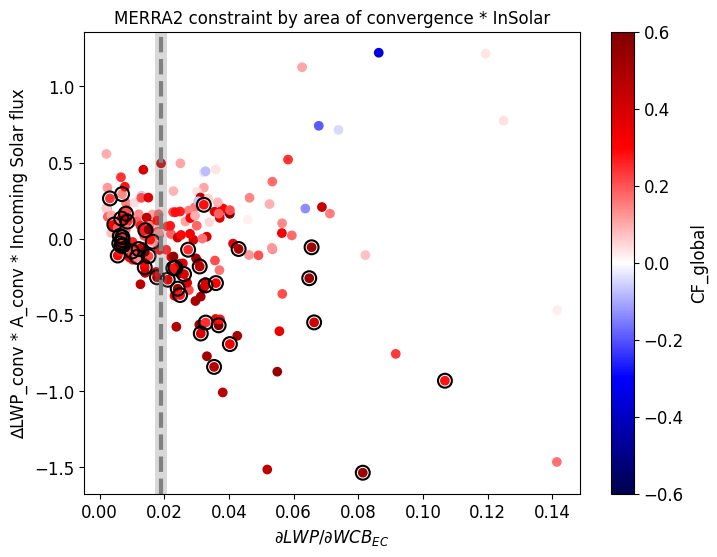

In [12]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
x_p = PPE_grad_LWP_WCB
y_p = final_data['ymap']
c_p = final_data['clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_global')
plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_WCB, color='grey', linestyle='--')
plt.axvspan(lower_bound_WCB, upper_bound_WCB, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂WCB_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

In [18]:
ind = np.isnan(x_p*y_p*c_p)==False
X = np.column_stack((x_p.data[ind], y_p.data[ind]))  # shape (254, 2)
y = c_p.data[ind]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R² Score: {r2:.4f}")


Test MSE: 0.0193
Test R² Score: 0.2450


# RF emulator (full dataset) - Barnes

In [13]:
'''https://github.com/eabarnes1010/course_objective_analysis/blob/main/code/random_forest_ozone_joshuatree.ipynb'''

'https://github.com/eabarnes1010/course_objective_analysis/blob/main/code/random_forest_ozone_joshuatree.ipynb'

In [14]:

import sys
import numpy as np
import seaborn as sb

import pandas as pd
import datetime
import tensorflow as tf
#import tensorflow.keras as keras
import sklearn
#import pydot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

2025-06-10 14:43:22.292813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/24.12/spack/opt/spack/openmpi/5.0.6/oneapi/2024.2.1/ptm3/lib:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/nvvm/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/extras/CUPTI/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/extras/Debugger/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/intel-oneapi-compilers/2024.2.1/gcc/12.4.0/iq3b/compiler/2024.2/opt/compiler/lib:/glade/u/apps/casper/24.12/spack/opt/spack/intel-oneapi-compilers/2024.2.1/gcc/12.4.0/iq3b/compiler/2024.2/lib:/glade/u/apps/casper/24.12/spack/opt/spack/gcc/12.4.0/5b5c/lib64:/glade/u/apps/casper/24.12/s

In [15]:
# Creating a numpy array for inputs and outputs
ind = np.isnan(x_p*y_p*c_p)==False
input = np.column_stack((x_p.data[ind], y_p.data[ind]))  # shape (254, 2)
output = c_p.data[ind]


In [16]:
# Printing the shapes of our input and output arrays (#samples , #dimension of input/output)
print('Input Array Shape:', input.shape)
print('Output Array Shape:', output.shape)

Input Array Shape: (199, 2)
Output Array Shape: (199,)


In [17]:
# Splitting into training, testing, validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: Train-test split (e.g., 80% train_val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

# Step 2: Split train_val into train and validation (e.g., 75% of 80% = 60% train, 20% val)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# building the model

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [29]:
### Here is where we actually build the model

# Create and Train the Random Forest Classifier
#-------------------------------------------------------------------------------------------------
# MODIFY: important tunable parameters (hyperparameters) for model
number_of_trees = 1000               # number of trees to "average" together to create a random forest
tree_depth = None                     # maximum depth allowed for each tree
node_split = 10                     # minimum number of training samples needed to split a node
leaf_samples = 5                   # minimum number of training samples required to make a leaf node
criterion = 'gini'                 # 'gini' or 'entropy'
bootstrap = True                  # whether to perform "bagging=bootstrap aggregating" or not
max_samples = None                 # number of samples to grab when training each tree IF bootstrap=True, otherwise None
class_weight = None                # class weights, default None. Use 'balanced' to weight by class frequency, or customize with format [{0:1.0,1:1.0}, {0:1.0,1:1.0}, {0:1.0,1:1.0}]
RAND_STATE = 13                    # specify random state for reproducibility
#-------------------------------------------------------------------------------------------------


In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=number_of_trees,
    max_depth=tree_depth,
    min_samples_split=node_split,
    min_samples_leaf=leaf_samples,
    bootstrap=bootstrap,
    max_samples=max_samples,
    random_state=RAND_STATE
)

# Train the model
rf.fit(X_train, y_train)


RandomForestRegressor(min_samples_leaf=5, min_samples_split=10,
                      n_estimators=1000, random_state=13)

In [31]:
Ptrain=rf.predict(X_train) # make predictions on the training dataset
# Pval=rf.predict(X_val) # make predictions on the validation set



R² Score: 0.5166930857046703
MSE: 0.014537792634660249
RMSE: 0.12057276904284918
MAE: 0.0902270789513489


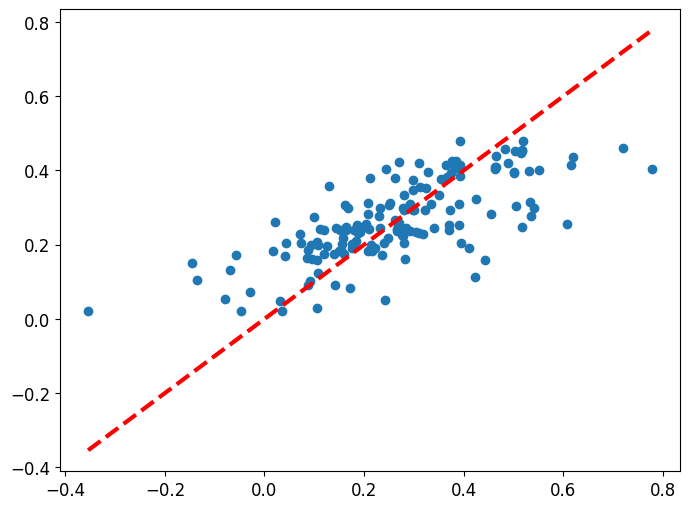

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(y_train, Ptrain)
print("R² Score:", r2)

mse = mean_squared_error(y_train, Ptrain)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_train, Ptrain)
print("MAE:", mae)

plt.scatter(y_train, Ptrain)
# plt.scatter(y_val, Pval, c='r')
min_val = min(np.min(y_train), np.min(Ptrain))
max_val = max(np.max(y_train), np.max(Ptrain))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.show()

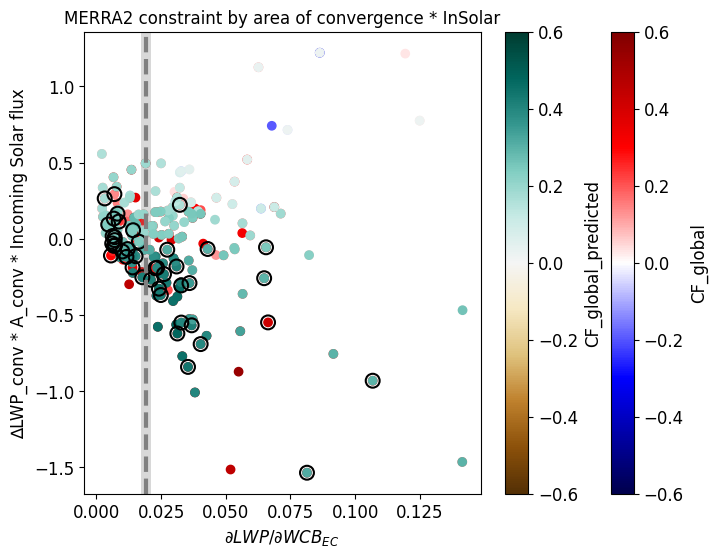

In [33]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
x_p = PPE_grad_LWP_WCB
y_p = final_data['ymap']
c_p = final_data['clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_global')

plt.axvline(x=obs_grad_LWP_WCB, color='grey', linestyle='--')
plt.axvspan(lower_bound_WCB, upper_bound_WCB, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂WCB_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')

plt.scatter(X_train[:,0], X_train[:,1], c=Ptrain, cmap='BrBG',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_global_predicted')
plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.show()

In [34]:
# Get min and max of each feature
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)


In [35]:
# Bootstrap sampling
num_samples = 1_000_000
indices = np.random.choice(len(X_train), size=num_samples, replace=True)
X_new = X_train[indices]


In [36]:
P_new = rf.predict(X_new)


In [37]:
P_new.shape

(1000000,)

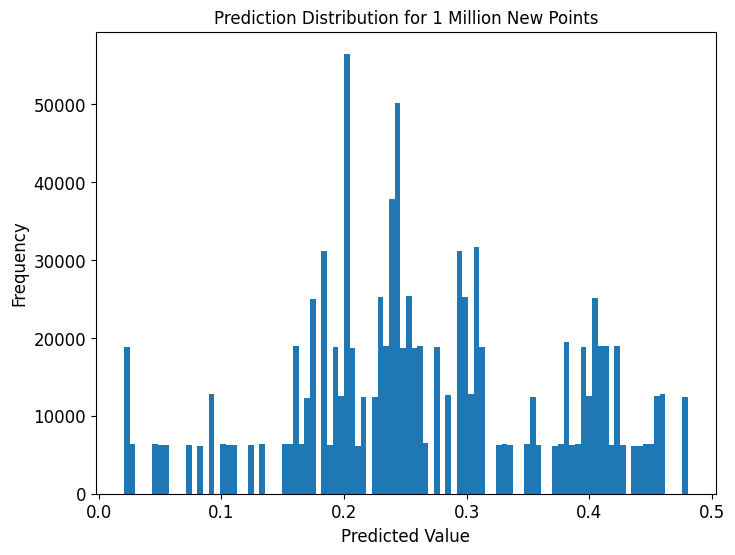

In [38]:
plt.hist(P_new, bins=100)
plt.title('Prediction Distribution for 1 Million New Points')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.show()


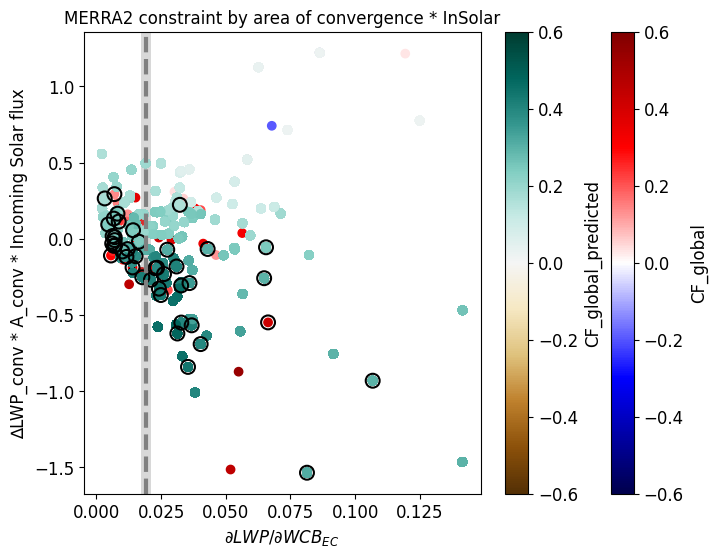

In [39]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
x_p = PPE_grad_LWP_WCB
y_p = final_data['ymap']
c_p = final_data['clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_global')

plt.axvline(x=obs_grad_LWP_WCB, color='grey', linestyle='--')
plt.axvspan(lower_bound_WCB, upper_bound_WCB, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂WCB_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')

plt.scatter(X_new[:,0], X_new[:,1], c=P_new, cmap='BrBG',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_global_predicted')
plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.show()

# predict for tropics, extratropics and subtropics separately

In [7]:
LWP_varn="dLWPmap_gol"; T_varn="dTSmap_gol"; ocean=False
Lv = 2264705.  # J/kg
### Load maps
file_names = {
    "dLWPmap": LWP_varn,
    "dTSmap": T_varn,
    "pe_maps_ol": "pe_maps_ol",
    "pe_maps_o": "pe_maps_o"
}
datasets = {var_name: load_xarray(file_name) for var_name, file_name in file_names.items()}

### ∆LWP map
dLWP_TSmap = datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
dLWP_TSmap = dLWP_TSmap.sortby('lon')

### cloud feedback
cf = (load_xarray('dSWCREmap')+load_xarray('dLWCREmap'))/datasets['dTSmap']
cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
cf = cf.sortby('lon')

### PD MC map
PDMC_QFLX_da = datasets['pe_maps_o' if ocean else 'pe_maps_ol']*86400

### converging area
convergence_mask = PDMC_QFLX_da.where(PDMC_QFLX_da > 0, other=np.nan)
# convergence_mask = PDMC_QFLX_da

### incoming solar flux  #downwelling SW flux at TOA
SW_d_list = []
run_numbers = []
for fnum in range(263):
    try:
        fnums = f"{fnum:03d}"
        SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
        SW_maps = np.mean(SWfn_list['data'], axis=0)
        # SW_mean = lat_weight_mean(SW_maps)
        SW_d_list.append(SW_maps)
        run_numbers.append(fnum)
    except FileNotFoundError:
        print(f'{fnums} not available.')
        continue
SW_d_list = np.array(SW_d_list)
SWD_da = xr.DataArray(data=SW_d_list,
                      coords={'runs': run_numbers,
                              'lat': SWfn_list['lat'],
                              'lon': SWfn_list['lon']},
                      dims=['runs','lat','lon'])
SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
SWD_da = SWD_da.sortby('lon')  # [Wm-2]
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
    land_mask_da = xr.DataArray(
        land_mask,
        coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
        dims=['lat', 'lon']
    )
    SWD_da = SWD_da * land_mask_da



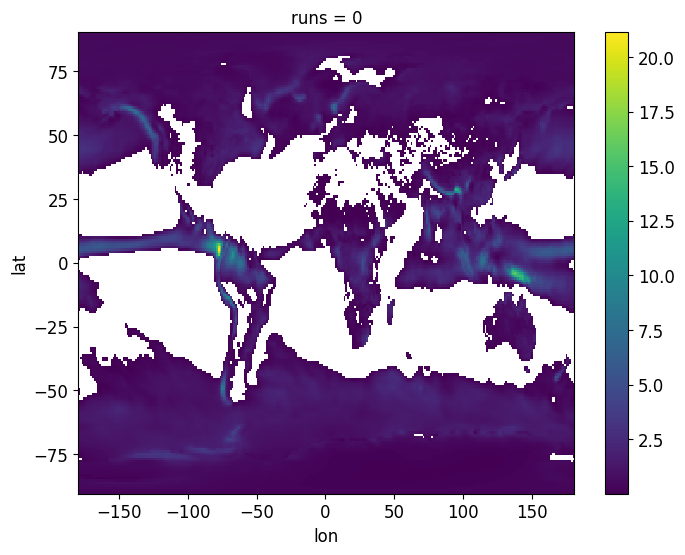

In [7]:
convergence_mask[0].plot()

In [8]:
conv_contrib = dLWP_TSmap*convergence_mask*SWD_da

In [9]:
### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

In [10]:
conv_filter = convergence_mask*SWD_da

In [11]:
# Tropics
tr_max = 23.5; st_max = 50
tropics = conv_contrib.sel(lat=slice(-tr_max, tr_max))
tr_cf = cf.sel(lat=slice(-tr_max, tr_max))
tr_conv_filter= conv_filter.sel(lat=slice(-tr_max, tr_max))

# Subtropics (Northern and Southern combined)
subtropics_north = conv_contrib.sel(lat=slice(tr_max, st_max))
subtropics_south = conv_contrib.sel(lat=slice(-st_max, -tr_max))
subtropics = xr.concat([subtropics_south, subtropics_north], dim='lat')
st_cf = xr.concat([cf.sel(lat=slice(tr_max, st_max)), cf.sel(lat=slice(-st_max, -tr_max))], dim='lat')
st_conv_filter= xr.concat([conv_filter.sel(lat=slice(tr_max, st_max)), conv_filter.sel(lat=slice(-st_max, -tr_max))], dim='lat')

# Extratropics (Northern and Southern combined)
extratropics_north = conv_contrib.sel(lat=slice(st_max, 90))
extratropics_south = conv_contrib.sel(lat=slice(-90, -st_max))
extratropics = xr.concat([extratropics_south, extratropics_north], dim='lat')
ex_cf = xr.concat([cf.sel(lat=slice(st_max, 90)), cf.sel(lat=slice(-90, -st_max))], dim='lat')
ex_conv_filter= xr.concat([conv_filter.sel(lat=slice(st_max, 90)), conv_filter.sel(lat=slice(-90, -st_max))], dim='lat')


In [12]:
conv_contrib_mean, conv_contrib_sem, conv_contrib_std = lat_weight_mean(conv_contrib)
tr_conv_contrib_mean, tr_conv_contrib_sem, tr_conv_contrib_std = lat_weight_mean(tropics)
st_conv_contrib_mean, st_conv_contrib_sem, st_conv_contrib_std = lat_weight_mean(subtropics)
ex_conv_contrib_mean, ex_conv_contrib_sem, ex_conv_contrib_std = lat_weight_mean(extratropics)

In [13]:
cf_mean, cf_sem, cf_std = lat_weight_mean(cf)
tr_cf_mean, tr_cf_sem, tr_cf_std = lat_weight_mean(tr_cf)
st_cf_mean, st_cf_sem, st_cf_std = lat_weight_mean(st_cf)
ex_cf_mean, ex_cf_sem, ex_cf_std = lat_weight_mean(ex_cf)

In [14]:
filter_conv = lat_weight_mean(conv_filter)[0]
tr_filter_conv = lat_weight_mean(tr_conv_filter)[0]
st_filter_conv = lat_weight_mean(st_conv_filter)[0]
ex_filter_conv = lat_weight_mean(ex_conv_filter)[0]

In [15]:
### global precipitation efficiency means
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs': file['runs']})  # [s-1]


In [16]:
### Select only common runs for all datasets
final_data_n = {
    "xmap": pe_gm_o,
    "ymap": conv_contrib_mean,
    "tr_ymap": tr_conv_contrib_mean,
    "st_ymap": st_conv_contrib_mean,
    "ex_ymap": ex_conv_contrib_mean,
    "clrmap": cf_mean,
    "tr_clrmap": tr_cf_mean,
    "st_clrmap": st_cf_mean,
    "ex_clrmap": ex_cf_mean,
    "filter": filtered_TOA_15,
    "filter2": filter_conv,
    "tr_filter2": tr_filter_conv,
    "st_filter2": st_filter_conv,
    "ex_filter2": ex_filter_conv
}
keys = list(final_data_n.keys())
common_members = final_data_n[keys[0]]["runs"].values
for name in keys:
    print(name)
    common_members = np.intersect1d(common_members, final_data_n[name]["runs"].values)
final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

xmap
ymap
tr_ymap
st_ymap
ex_ymap
clrmap
tr_clrmap
st_clrmap
ex_clrmap
filter
filter2
tr_filter2
st_filter2
ex_filter2


In [17]:
#### MERRA2 constraint by area of convergence * SWD
## Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = merraMC.where(merraMC > 0, other=np.nan)
merra_conv_sw = merra_conv_area*merraSW

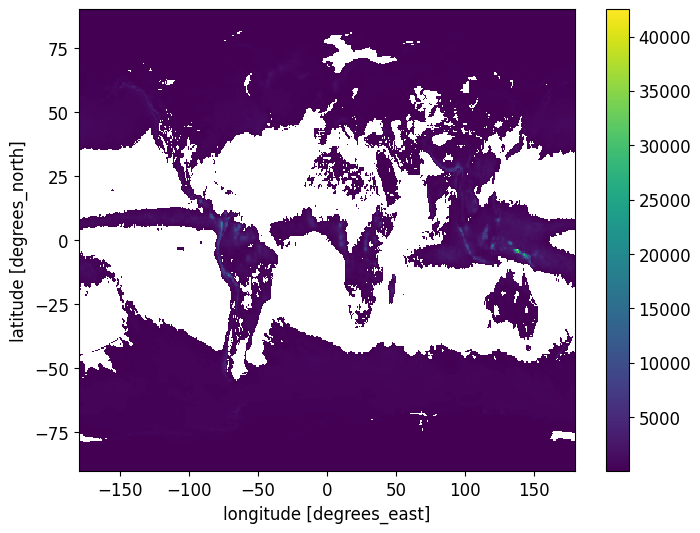

In [18]:
merra_conv_sw.plot()

In [18]:
## Constrained Pe
from cyclone_obs import *
from cyclone_metrics import *
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
obs_dict = cyclone_obs()
# PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)
PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)

In [22]:
# cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
# wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
# num_bins = 10
# ind = ~np.isnan(wcb * cloudlwp)

# # Calculate bins and statistics in one go
# bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
# lwp_bin, wcb_bin = bin_stats.statistic
# count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
# obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

# obs_grad_LWP_WCB = obs_grad.copy()

# lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
# upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

In [19]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']*24  #[mm/day]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

print(obs_grad)

obs_grad_LWP_PRC = obs_grad

lower_bound_PRC = obs_grad_LWP_PRC - 0.35 * obs_grad_LWP_PRC
upper_bound_PRC = obs_grad_LWP_PRC + 0.35 * obs_grad_LWP_PRC

0.008106015839806293


981.1377699200697


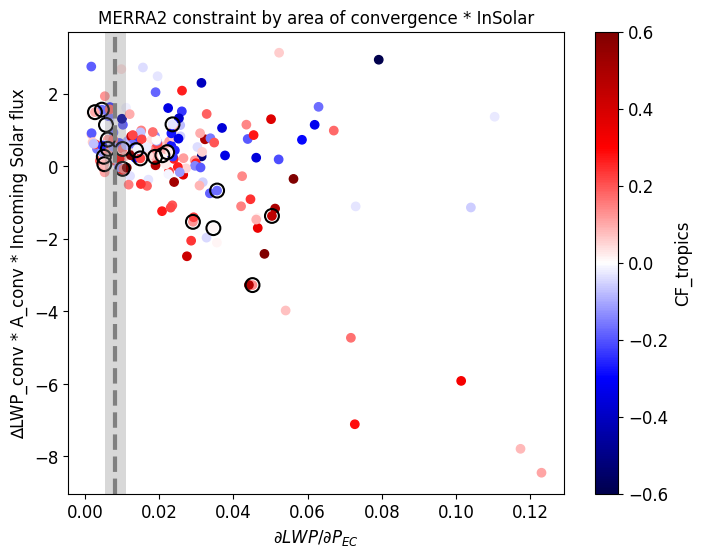

In [36]:
sel_merra_conv_sw = merra_conv_sw.sel(lat=slice(-tr_max, tr_max))
tr_merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(tr_merraMC_mean.values)
tr_obs_constraint_lower = tr_merraMC_mean.values - merraMC_sem.values
tr_obs_constraint_upper = tr_merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['tr_filter2']
tr_constrained = (PPE_conv_SWD.values >= tr_obs_constraint_lower) & (PPE_conv_SWD.values <= tr_obs_constraint_upper)

x_p = PPE_grad_LWP_PRC
y_p = final_data['tr_ymap']
c_p = final_data['tr_clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_tropics')
plt.scatter(x_p.sel(runs=tr_constrained), y_p.sel(runs=tr_constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

344.5618100417757


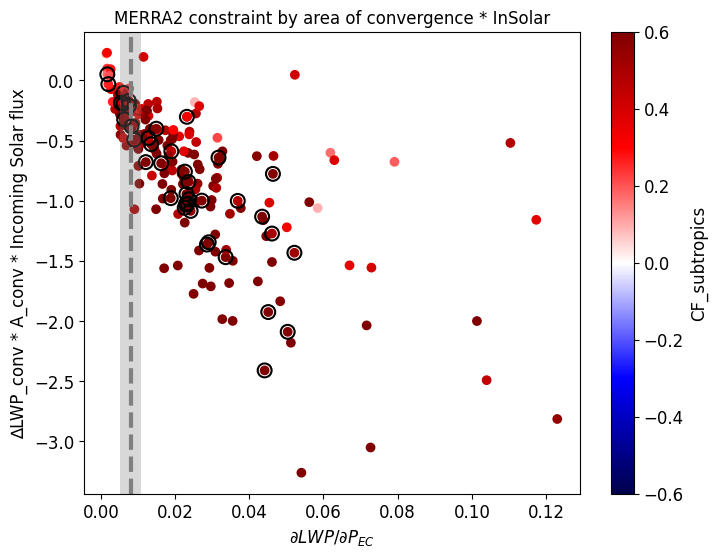

In [37]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
sel_merra_conv_sw = xr.concat([merra_conv_sw.sel(lat=slice(tr_max, st_max)), merra_conv_sw.sel(lat=slice(-st_max, -tr_max))], dim='lat')
st_merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(st_merraMC_mean.values)
st_obs_constraint_lower = st_merraMC_mean.values - merraMC_sem.values
st_obs_constraint_upper = st_merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['st_filter2']
st_constrained = (PPE_conv_SWD.values >= st_obs_constraint_lower) & (PPE_conv_SWD.values <= st_obs_constraint_upper)

x_p = PPE_grad_LWP_PRC
y_p = final_data['st_ymap']
c_p = final_data['st_clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_subtropics')
plt.scatter(x_p.sel(runs=st_constrained), y_p.sel(runs=st_constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

256.8365084498096


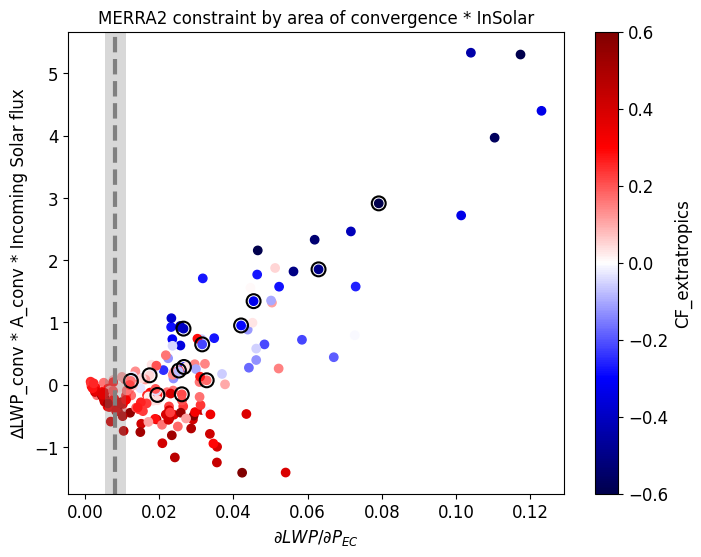

In [38]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
sel_merra_conv_sw = xr.concat([merra_conv_sw.sel(lat=slice(st_max, 90)), merra_conv_sw.sel(lat=slice(-90, -st_max))], dim='lat')
ex_merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(ex_merraMC_mean.values)
ex_obs_constraint_lower = ex_merraMC_mean.values - merraMC_sem.values
ex_obs_constraint_upper = ex_merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['st_filter2']
ex_constrained = (PPE_conv_SWD.values >= ex_obs_constraint_lower) & (PPE_conv_SWD.values <= ex_obs_constraint_upper)

x_p = PPE_grad_LWP_PRC
y_p = final_data['ex_ymap']
c_p = final_data['ex_clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_extratropics')
plt.scatter(x_p.sel(runs=ex_constrained), y_p.sel(runs=ex_constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

# emulated

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

x_p = PPE_grad_LWP_PRC
y_p = final_data['tr_ymap']
c_p = final_data['tr_clrmap']

def emulate_regimes(x_p, y_p, c_p):
    ind = np.isnan(x_p*y_p*c_p)==False
    input = np.column_stack((x_p.data[ind], y_p.data[ind]))
    output = c_p.data[ind]

    X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

    # Create and Train the Random Forest Classifier
    #-------------------------------------------------------------------------------------------------
    # MODIFY: important tunable parameters (hyperparameters) for model
    number_of_trees = 200               # number of trees to "average" together to create a random forest
    tree_depth = None                   # maximum depth allowed for each tree
    node_split = 10                     # minimum number of training samples needed to split a node
    leaf_samples = 5                   # minimum number of training samples required to make a leaf node
    criterion = 'gini'                 # 'gini' or 'entropy'
    bootstrap = True                  # whether to perform "bagging=bootstrap aggregating" or not
    max_samples = None                 # number of samples to grab when training each tree IF bootstrap=True, otherwise None
    class_weight = None                # class weights, default None. Use 'balanced' to weight by class frequency, or customize with format [{0:1.0,1:1.0}, {0:1.0,1:1.0}, {0:1.0,1:1.0}]
    RAND_STATE = 13                    # specify random state for reproducibility
    #-------------------------------------------------------------------------------------------------

    rf = RandomForestRegressor(
        n_estimators=number_of_trees,
        max_depth=tree_depth,
        min_samples_split=node_split,
        min_samples_leaf=leaf_samples,
        bootstrap=bootstrap,
        max_samples=max_samples,
        random_state=RAND_STATE
    )
    
    rf.fit(X_train, y_train)   # Train the model
    Ptrain=rf.predict(X_train) # make predictions on the training dataset

    r2 = r2_score(y_train, Ptrain)
    print("R² Score:", r2)  
    mse = mean_squared_error(y_train, Ptrain)
    rmse = np.sqrt(mse)
    print("MSE:", mse)
    print("RMSE:", rmse)
    mae = mean_absolute_error(y_train, Ptrain)
    print("MAE:", mae)

    # emulate
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    # Bootstrap sampling
    # num_samples = 1_000_000
    # indices = np.random.choice(len(X_train), size=num_samples, replace=True)
    # X_new = X_train[indices]
    # P_new = rf.predict(X_new)

    # GMM sampling
    from sklearn.mixture import GaussianMixture  
    # Fit GMM to your 2D input data
    X_train_2D = X_train[:, :2]  # assuming first 2 columns are X1 and X2
    gmm = GaussianMixture(n_components=3, random_state=0)  # 3 components example
    gmm.fit(X_train_2D)
    
    # Generate new synthetic points preserving dependency structure
    n_samples = 1_000_000
    X_new_2D, _ = gmm.sample(n_samples)
    
    # Optionally: predict Y using your model
    P_new = rf.predict(X_new_2D)
    X_new = X_new_2D

    return X_new, P_new

    

NameError: name 'PPE_grad_LWP_PRC' is not defined

579.9966633207322
R² Score: 0.5477873535519986
MSE: 0.013602482162741743
RMSE: 0.11662967959632635
MAE: 0.08690954276162163


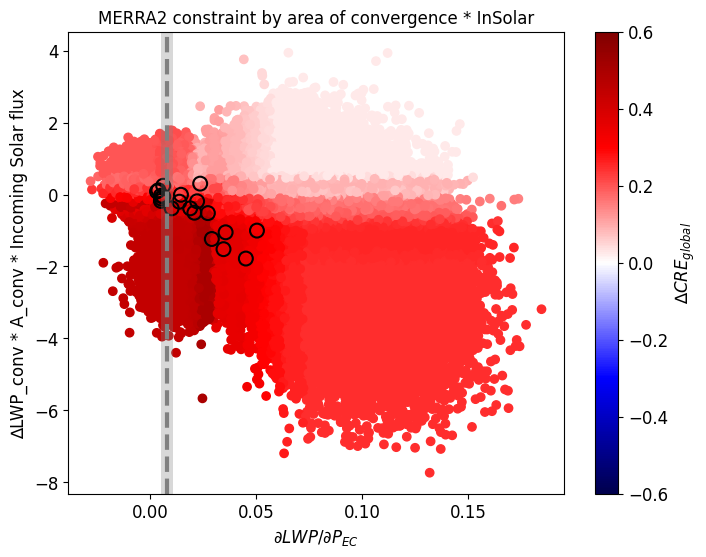

In [22]:
sel_merra_conv_sw = merra_conv_sw.copy()
merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(merraMC_mean.values)
obs_constraint_lower = merraMC_mean.values - merraMC_sem.values
obs_constraint_upper = merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['filter2']
constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

x_p = PPE_grad_LWP_PRC
y_p = final_data['ymap']
c_p = final_data['clrmap']
X_new, P_new = emulate_regimes(x_p, y_p, c_p)
# plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
#            vmin=-0.6, vmax=0.6)
# plt.colorbar(label='CF_tropics')
plt.scatter(X_new[:,0], X_new[:,1], c=P_new, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='$∆CRE_{global}$')
plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

981.1377699200697
R² Score: 0.4007619513800569
MSE: 0.029309113335229082
RMSE: 0.1711990459530341
MAE: 0.13323949947188699


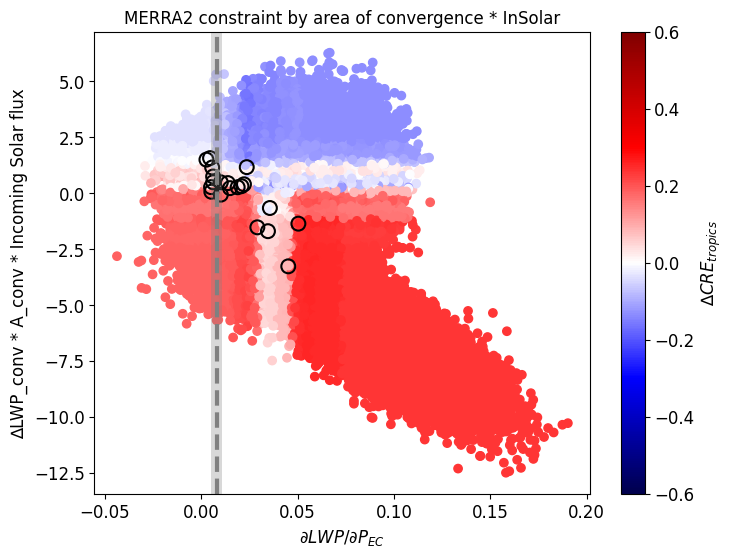

In [40]:
sel_merra_conv_sw = merra_conv_sw.sel(lat=slice(-tr_max, tr_max))
tr_merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(tr_merraMC_mean.values)
tr_obs_constraint_lower = tr_merraMC_mean.values - merraMC_sem.values
tr_obs_constraint_upper = tr_merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['tr_filter2']
tr_constrained = (PPE_conv_SWD.values >= tr_obs_constraint_lower) & (PPE_conv_SWD.values <= tr_obs_constraint_upper)

x_p = PPE_grad_LWP_PRC
y_p = final_data['tr_ymap']
c_p = final_data['tr_clrmap']
X_new, P_new = emulate_regimes(x_p, y_p, c_p)
# plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
#            vmin=-0.6, vmax=0.6)
# plt.colorbar(label='CF_tropics')
plt.scatter(X_new[:,0], X_new[:,1], c=P_new, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='$∆CRE_{tropics}$')
plt.scatter(x_p.sel(runs=tr_constrained), y_p.sel(runs=tr_constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

344.5618100417757
R² Score: 0.6485456733558967
MSE: 0.020220304816415288
RMSE: 0.1421981181887274
MAE: 0.10691127278240402


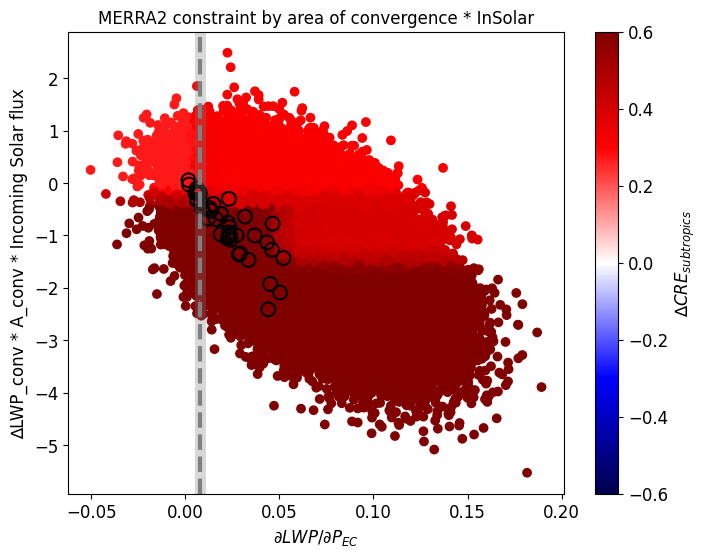

In [41]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
sel_merra_conv_sw = xr.concat([merra_conv_sw.sel(lat=slice(tr_max, st_max)), merra_conv_sw.sel(lat=slice(-st_max, -tr_max))], dim='lat')
st_merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(st_merraMC_mean.values)
st_obs_constraint_lower = st_merraMC_mean.values - merraMC_sem.values
st_obs_constraint_upper = st_merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['st_filter2']
st_constrained = (PPE_conv_SWD.values >= st_obs_constraint_lower) & (PPE_conv_SWD.values <= st_obs_constraint_upper)

x_p = PPE_grad_LWP_PRC
y_p = final_data['st_ymap']
c_p = final_data['st_clrmap']
X_new, P_new = emulate_regimes(x_p, y_p, c_p)
plt.scatter(X_new[:,0], X_new[:,1], c=P_new, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='$∆CRE_{subtropics}$')
plt.scatter(x_p.sel(runs=st_constrained), y_p.sel(runs=st_constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

256.8365084498096
R² Score: 0.8260227902119299
MSE: 0.013639773222735097
RMSE: 0.11678943968842002
MAE: 0.08854430630793576


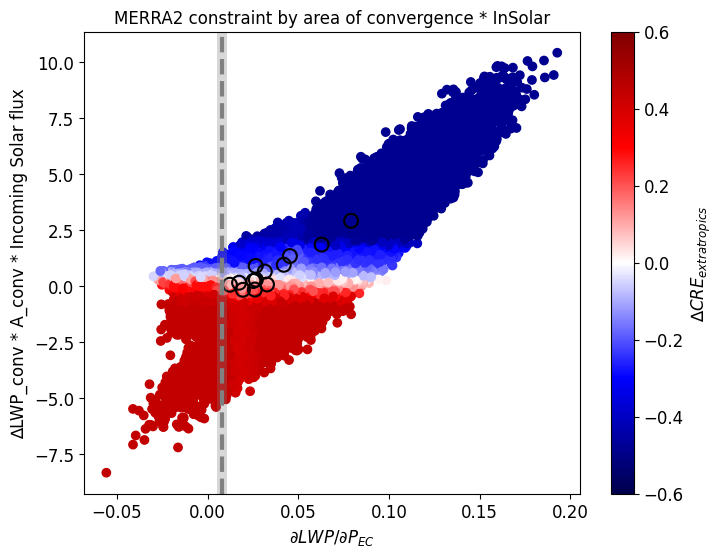

In [42]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
sel_merra_conv_sw = xr.concat([merra_conv_sw.sel(lat=slice(st_max, 90)), merra_conv_sw.sel(lat=slice(-90, -st_max))], dim='lat')
ex_merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(ex_merraMC_mean.values)
ex_obs_constraint_lower = ex_merraMC_mean.values - merraMC_sem.values
ex_obs_constraint_upper = ex_merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['st_filter2']
ex_constrained = (PPE_conv_SWD.values >= ex_obs_constraint_lower) & (PPE_conv_SWD.values <= ex_obs_constraint_upper)

x_p = PPE_grad_LWP_PRC
y_p = final_data['ex_ymap']
c_p = final_data['ex_clrmap']
X_new, P_new = emulate_regimes(x_p, y_p, c_p)
plt.scatter(X_new[:,0], X_new[:,1], c=P_new, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='$∆CRE_{extratropics}$')
plt.scatter(x_p.sel(runs=ex_constrained), y_p.sel(runs=ex_constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

In [59]:
prc_en_constraint = np.where(
    (X_new[:, 0] >= lower_bound_PRC) & 
    (X_new[:, 0] <= upper_bound_PRC)
)[0]
print(prc_en_constraint)

[     6      7      9 ... 999023 999327 999745]


In [60]:
y_min = y_p.sel(runs=tr_constrained).min().values
y_max = y_p.sel(runs=tr_constrained).max().values


In [61]:
tr_final_constrained_runs = prc_en_constraint[
    (X_new[:, 1][prc_en_constraint] >= y_min) & 
    (X_new[:, 1][prc_en_constraint] <= y_max)
]


In [62]:
tr_final_constrained_runs.shape

(116522,)

In [63]:
prc_en_constraint.shape

(128542,)

In [64]:
num_unique = len(set(P_new[tr_final_constrained_runs]))
print("Number of unique values:", num_unique)


Number of unique values: 8632


# emulate global using predictors separately

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture  
import numpy as np

def emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p):
    # Determine valid (non-NaN) points
    ind = np.isnan(x_p * y_p1 * y_p2 * y_p3 * c_p) == False
    
    # Stack all predictors (now 4 inputs)
    input = np.column_stack((
        x_p.data[ind], 
        y_p1.data[ind], 
        y_p2.data[ind], 
        y_p3.data[ind]
    ))
    output = c_p.data[ind]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        input, output, test_size=0.2, random_state=42
    )

    # Random Forest Regressor hyperparameters
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        max_samples=None,
        random_state=13
    )
    
    # Fit model
    rf.fit(X_train, y_train)
    Ptrain = rf.predict(X_train)

    # Metrics on training data
    r2 = r2_score(y_train, Ptrain)
    mse = mean_squared_error(y_train, Ptrain)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, Ptrain)
    
    print("Training Performance:")
    print("R² Score:", r2)  
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)

    # Emulate regime sampling via GMM on full 4D space
    n_samples = 1_000_000
    gmm = GaussianMixture(n_components=3, random_state=0)
    gmm.fit(X_train)  # Now fitting on full 4D space
    
    X_new, _ = gmm.sample(n_samples)  # Sample in 4D space
    P_new = rf.predict(X_new)         # Predict using RF model

    return X_new, P_new


In [16]:
LWP_varn="dLWPmap_gol"; T_varn="dTSmap_gol"; ocean=False
Lv = 2264705.  # J/kg
### Load maps
file_names = {
    "dLWPmap": LWP_varn,
    "dTSmap": T_varn,
    "pe_maps_ol": "pe_maps_ol",
    "pe_maps_o": "pe_maps_o"
}
datasets = {var_name: load_xarray(file_name) for var_name, file_name in file_names.items()}

### ∆LWP map
dLWP_TSmap = datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
dLWP_TSmap = dLWP_TSmap.sortby('lon')

### cloud feedback
cf = (load_xarray('dSWCREmap')+load_xarray('dLWCREmap'))/datasets['dTSmap']
cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
cf = cf.sortby('lon')

### PD MC map
PDMC_QFLX_da = datasets['pe_maps_o' if ocean else 'pe_maps_ol']*86400

### converging area
convergence_mask = PDMC_QFLX_da.where(PDMC_QFLX_da > 0, other=np.nan)
# convergence_mask = PDMC_QFLX_da

### incoming solar flux  #downwelling SW flux at TOA
SW_d_list = []
run_numbers = []
for fnum in range(263):
    try:
        fnums = f"{fnum:03d}"
        SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
        SW_maps = np.mean(SWfn_list['data'], axis=0)
        # SW_mean = lat_weight_mean(SW_maps)
        SW_d_list.append(SW_maps)
        run_numbers.append(fnum)
    except FileNotFoundError:
        print(f'{fnums} not available.')
        continue
SW_d_list = np.array(SW_d_list)
SWD_da = xr.DataArray(data=SW_d_list,
                      coords={'runs': run_numbers,
                              'lat': SWfn_list['lat'],
                              'lon': SWfn_list['lon']},
                      dims=['runs','lat','lon'])
SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
SWD_da = SWD_da.sortby('lon')  # [Wm-2]
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
    land_mask_da = xr.DataArray(
        land_mask,
        coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
        dims=['lat', 'lon']
    )
    SWD_da = SWD_da * land_mask_da



In [17]:
### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

In [18]:
### global precipitation efficiency means
# file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
# pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs': file['runs']})  # [s-1]


In [19]:
def sel_regime(xarray, lat_min, lat_max):
    north = xarray.sel(lat=slice(lat_min, lat_max))
    south = xarray.sel(lat=slice(-lat_max, -lat_min))
    xarray_sel = xr.concat([south, north], dim='lat')

    return xarray_sel


In [20]:
dLWP_TSmap_sel = sel_regime(dLWP_TSmap,0,90)
convergence_mask_sel = sel_regime(convergence_mask,0,90)
SWD_da_sel = sel_regime(SWD_da,0,90)

In [22]:
dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
cf_mean, cf_sem, cf_std = lat_weight_mean(cf)
conv_filter = convergence_mask_sel*SWD_da_sel
filter_conv = lat_weight_mean(conv_filter)[0]

In [23]:
## Constrained Pe
from cyclone_obs import *
from cyclone_metrics import *
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
obs_dict = cyclone_obs()
# PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)
# PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)

In [24]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']*24  #[mm/day]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

print(obs_grad)

obs_grad_LWP_PRC = obs_grad

lower_bound_PRC = obs_grad_LWP_PRC - 0.35 * obs_grad_LWP_PRC
upper_bound_PRC = obs_grad_LWP_PRC + 0.35 * obs_grad_LWP_PRC

0.008106015839806293


In [25]:
### Select only common runs for all datasets
final_data_n = {
    "xmap": PPE_grad_LWP_PRC,
    "ymap1": dLWP_TSmap_sel_mean,
    "ymap2": convergence_mask_sel_mean,
    "ymap3": SWD_da_sel_mean,
    "clrmap": cf_mean,
    "filter": filtered_TOA_15,
    "filter2": filter_conv,
}
keys = list(final_data_n.keys())
common_members = final_data_n[keys[0]]["runs"].values
for name in keys:
    print(name)
    common_members = np.intersect1d(common_members, final_data_n[name]["runs"].values)
final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

xmap
ymap1
ymap2
ymap3
clrmap
filter
filter2


In [8]:
# conv_contrib = dLWP_TSmap*convergence_mask*SWD_da

In [10]:
# conv_filter = convergence_mask*SWD_da

In [11]:
# # Tropics
# tr_max = 23.5; st_max = 50
# tropics = conv_contrib.sel(lat=slice(-tr_max, tr_max))
# tr_cf = cf.sel(lat=slice(-tr_max, tr_max))
# tr_conv_filter= conv_filter.sel(lat=slice(-tr_max, tr_max))

# # Subtropics (Northern and Southern combined)
# subtropics_north = conv_contrib.sel(lat=slice(tr_max, st_max))
# subtropics_south = conv_contrib.sel(lat=slice(-st_max, -tr_max))
# subtropics = xr.concat([subtropics_south, subtropics_north], dim='lat')
# st_cf = xr.concat([cf.sel(lat=slice(tr_max, st_max)), cf.sel(lat=slice(-st_max, -tr_max))], dim='lat')
# st_conv_filter= xr.concat([conv_filter.sel(lat=slice(tr_max, st_max)), conv_filter.sel(lat=slice(-st_max, -tr_max))], dim='lat')

# # Extratropics (Northern and Southern combined)
# extratropics_north = conv_contrib.sel(lat=slice(st_max, 90))
# extratropics_south = conv_contrib.sel(lat=slice(-90, -st_max))
# extratropics = xr.concat([extratropics_south, extratropics_north], dim='lat')
# ex_cf = xr.concat([cf.sel(lat=slice(st_max, 90)), cf.sel(lat=slice(-90, -st_max))], dim='lat')
# ex_conv_filter= xr.concat([conv_filter.sel(lat=slice(st_max, 90)), conv_filter.sel(lat=slice(-90, -st_max))], dim='lat')


In [12]:
# conv_contrib_mean, conv_contrib_sem, conv_contrib_std = lat_weight_mean(conv_contrib)
# tr_conv_contrib_mean, tr_conv_contrib_sem, tr_conv_contrib_std = lat_weight_mean(tropics)
# st_conv_contrib_mean, st_conv_contrib_sem, st_conv_contrib_std = lat_weight_mean(subtropics)
# ex_conv_contrib_mean, ex_conv_contrib_sem, ex_conv_contrib_std = lat_weight_mean(extratropics)

In [13]:
# cf_mean, cf_sem, cf_std = lat_weight_mean(cf)
# tr_cf_mean, tr_cf_sem, tr_cf_std = lat_weight_mean(tr_cf)
# st_cf_mean, st_cf_sem, st_cf_std = lat_weight_mean(st_cf)
# ex_cf_mean, ex_cf_sem, ex_cf_std = lat_weight_mean(ex_cf)

In [14]:
# filter_conv = lat_weight_mean(conv_filter)[0]
# tr_filter_conv = lat_weight_mean(tr_conv_filter)[0]
# st_filter_conv = lat_weight_mean(st_conv_filter)[0]
# ex_filter_conv = lat_weight_mean(ex_conv_filter)[0]

In [26]:
# ### Select only common runs for all datasets
# final_data_n = {
#     "xmap": pe_gm_o,
#     "ymap": conv_contrib_mean,
#     "tr_ymap": tr_conv_contrib_mean,
#     "st_ymap": st_conv_contrib_mean,
#     "ex_ymap": ex_conv_contrib_mean,
#     "clrmap": cf_mean,
#     "tr_clrmap": tr_cf_mean,
#     "st_clrmap": st_cf_mean,
#     "ex_clrmap": ex_cf_mean,
#     "filter": filtered_TOA_15,
#     "filter2": filter_conv,
#     "tr_filter2": tr_filter_conv,
#     "st_filter2": st_filter_conv,
#     "ex_filter2": ex_filter_conv
# }
# keys = list(final_data_n.keys())
# common_members = final_data_n[keys[0]]["runs"].values
# for name in keys:
#     print(name)
#     common_members = np.intersect1d(common_members, final_data_n[name]["runs"].values)
# final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

In [27]:
#### MERRA2 constraint by area of convergence * SWD
## Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = merraMC.where(merraMC > 0, other=np.nan)
merra_conv_sw = merra_conv_area*merraSW

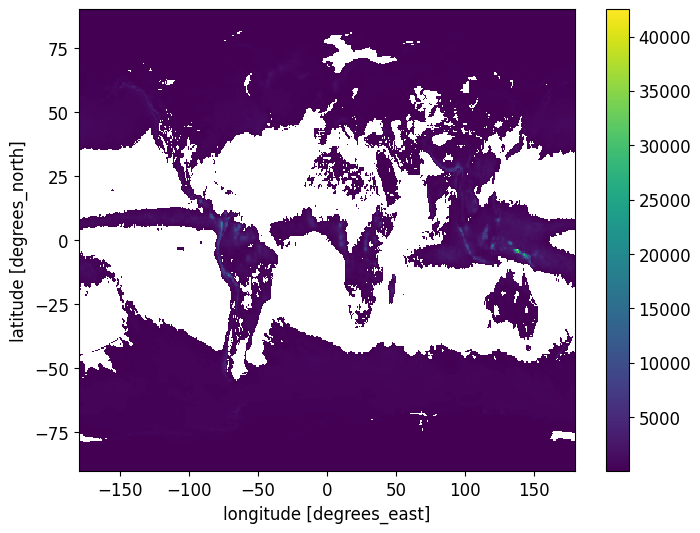

In [28]:
merra_conv_sw.plot()

In [29]:
# ## Constrained Pe
# from cyclone_obs import *
# from cyclone_metrics import *
# PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
# obs_dict = cyclone_obs()
# # PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)
# PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)

In [22]:
# cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
# wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
# num_bins = 10
# ind = ~np.isnan(wcb * cloudlwp)

# # Calculate bins and statistics in one go
# bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
# lwp_bin, wcb_bin = bin_stats.statistic
# count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
# obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

# obs_grad_LWP_WCB = obs_grad.copy()

# lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
# upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

In [30]:
# cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
# prc = obs_dict['MWprecipitation']*24  #[mm/day]
# num_bins = 10
# ind = np.isnan(prc*cloudlwp)==False

# ### take weighted bins
# lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
# prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
# count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
# obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

# print(obs_grad)

# obs_grad_LWP_PRC = obs_grad

# lower_bound_PRC = obs_grad_LWP_PRC - 0.35 * obs_grad_LWP_PRC
# upper_bound_PRC = obs_grad_LWP_PRC + 0.35 * obs_grad_LWP_PRC

579.9966633207326
Training Performance:
R² Score: 0.6950404611630056
MSE: 0.009173132861212794
RMSE: 0.09577647342230133
MAE: 0.07210175398459599


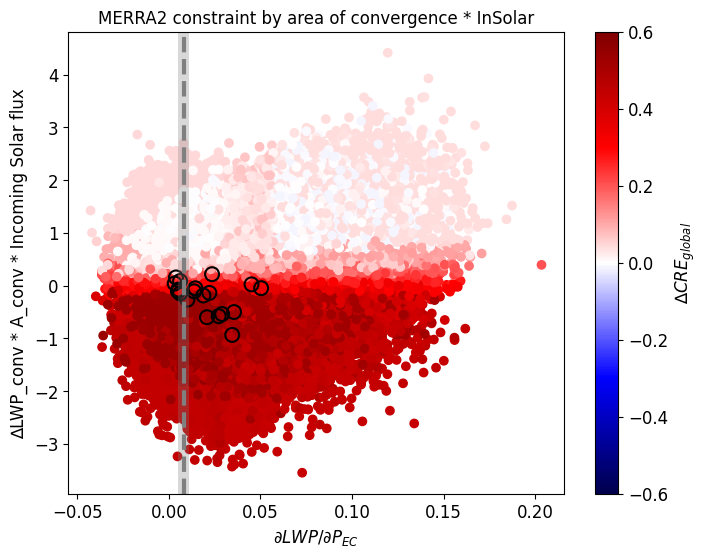

In [33]:
sel_merra_conv_sw = sel_regime(merra_conv_sw, 0, 90)
merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
print(merraMC_mean.values)
obs_constraint_lower = merraMC_mean.values - merraMC_sem.values
obs_constraint_upper = merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['filter2']
constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

x_p = final_data['xmap']
y_p1 = final_data['ymap1']
y_p2 = final_data['ymap2']
y_p3 = final_data['ymap3']
y_p = y_p1*y_p2*y_p3
c_p = final_data['clrmap']
X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p)
# plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
#            vmin=-0.6, vmax=0.6)
# plt.colorbar(label='CF_tropics')
plt.scatter(X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], c=P_new, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='$∆CRE_{global}$')
plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_PRC, color='grey', linestyle='--')
plt.axvspan(lower_bound_PRC, upper_bound_PRC, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂P_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()